In [9]:
import pandas as pd

# 1. Read the full WHO CSV
df = pd.read_csv('alcohol_by_WHO.csv')

# 2. Keep only the rows where Dim1ValueCode == 'ALCOHOLTYPE_SA_TOTAL'
#    (i.e. total recorded alcohol, 15+)
df = df[df['Dim1ValueCode'] == 'ALCOHOLTYPE_SA_TOTAL']

# 3. Select just the columns you need, then rename them
df_small = df[[
    'SpatialDimValueCode',  # e.g. 'AFG'
    'Location',             # e.g. 'Afghanistan'
    'Period',               # e.g. 2019
    'FactValueNumeric'      # e.g. 0.013 (litres per capita)
]].copy()

df_small.columns = [
    'country_code',
    'country_name',
    'year',
    'alcohol_consumption_per_capita'
]

df_small.sample(5)  # Show a few rows of the new DataFrame


,country_code,country_name,year,alcohol_consumption_per_capita
630,PRT,Portugal,2016,10.320
3570,DMA,Dominica,2001,8.580
385,BTN,Bhutan,2017,0.066
46,RWA,Rwanda,2019,1.350
336,SUR,Suriname,2018,6.260


In [12]:
df_small.info()  # Check the data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3766 entries, 0 to 3765
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country_code                    3766 non-null   object 
 1   country_name                    3766 non-null   object 
 2   year                            3766 non-null   int64  
 3   alcohol_consumption_per_capita  3766 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 117.8+ KB


In [10]:
# --- build the Greenland DataFrame ------------
grl_years = list(range(2000, 2020))
grl_values = [
    13.50,12.59,12.44,11.60,11.65,
    12.11,11.68,11.97,10.55,10.63,
    10.43, 9.79, 9.71, 8.81, 8.59,
     8.28, 8.72, 8.41, 7.42, 7.60
]

grl_df = pd.DataFrame({
    'country_code': ['GRL'] * len(grl_years),
    'country_name': ['Greenland'] * len(grl_years),
    'year': grl_years,
    'alcohol_consumption_per_capita': grl_values
})

# --- append & clean ----------------------------
df_combined = pd.concat([df_small, grl_df], ignore_index=True)

# make sure types line up
df_combined['year'] = df_combined['year'].astype(int)
df_combined['alcohol_consumption_per_capita'] = df_combined['alcohol_consumption_per_capita'].astype(float)

# (optional) sort for readability
df_combined = df_combined.sort_values(['country_code','year']).reset_index(drop=True)

# quick sanity‐check: show Greenland rows
print(df_combined[df_combined['country_code']=='GRL'])

     country_code country_name  year  alcohol_consumption_per_capita
1420          GRL    Greenland  2000                           13.50
1421          GRL    Greenland  2001                           12.59
1422          GRL    Greenland  2002                           12.44
1423          GRL    Greenland  2003                           11.60
1424          GRL    Greenland  2004                           11.65
1425          GRL    Greenland  2005                           12.11
1426          GRL    Greenland  2006                           11.68
1427          GRL    Greenland  2007                           11.97
1428          GRL    Greenland  2008                           10.55
1429          GRL    Greenland  2009                           10.63
1430          GRL    Greenland  2010                           10.43
1431          GRL    Greenland  2011                            9.79
1432          GRL    Greenland  2012                            9.71
1433          GRL    Greenland  20

In [11]:
df_combined.info()  # Show the DataFrame info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786 entries, 0 to 3785
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country_code                    3786 non-null   object 
 1   country_name                    3786 non-null   object 
 2   year                            3786 non-null   int64  
 3   alcohol_consumption_per_capita  3786 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 118.4+ KB


In [14]:
df_combined.to_csv('alcohol_cleaned.csv', index=False)

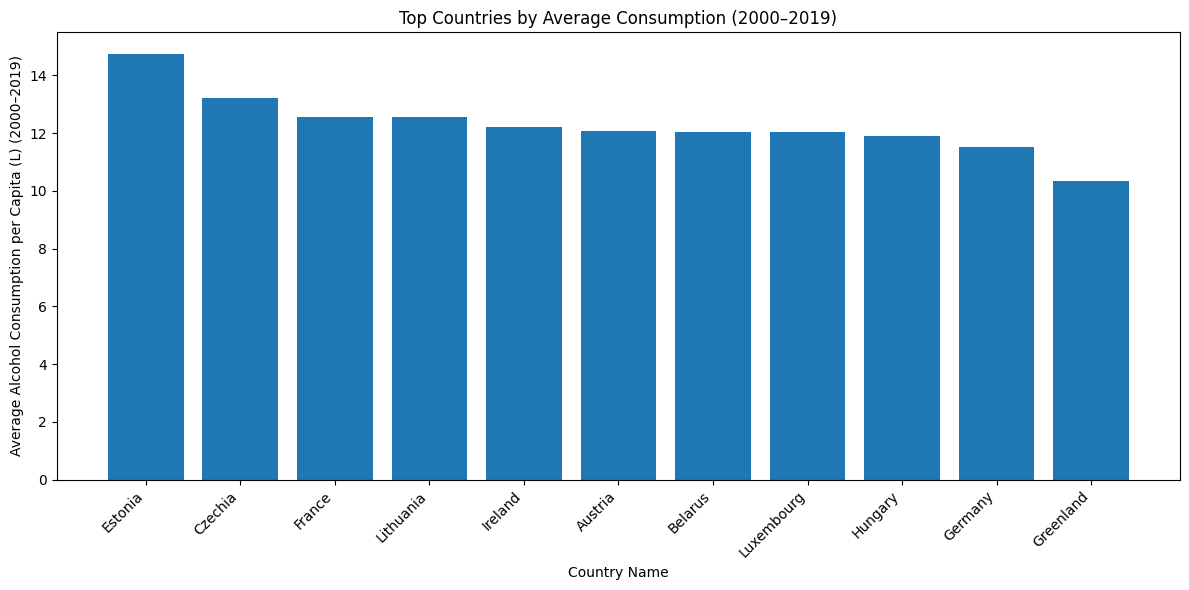

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your merged dataset
df = pd.read_csv('alcohol_cleaned.csv')  # ← adjust this

# 3. Filter to 2000–2019
df_period = df[(df['year'] >= 2000) & (df['year'] <= 2019)]

# 4. Compute mean consumption per country
mean_consumption = (
    df_period
    .groupby('country_name', as_index=False)['alcohol_consumption_per_capita']
    .mean()
)

# 5. Pick Top 10
top10 = mean_consumption.nlargest(10, 'alcohol_consumption_per_capita')

# 6. Extract Greenland’s mean
greenland_mean = mean_consumption[mean_consumption['country_name'] == 'Greenland']

# 7. Append Greenland (if not already in top10)
combined = pd.concat([top10, greenland_mean]).drop_duplicates('country_name')

# 8. Plot all bars
plt.figure(figsize=(12, 6))
plt.bar(combined['country_name'], combined['alcohol_consumption_per_capita'])
plt.xlabel('Country Name')
plt.ylabel('Average Alcohol Consumption per Capita (L) (2000–2019)')
plt.title('Top Countries by Average Consumption (2000–2019)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# 1. Load, skipping the first 4 rows as before
unemployment = pd.read_csv('unemployment.csv', skiprows=4)

# 2. Define the list of years you care about
years = [str(y) for y in range(2000, 2020)]

# 3. Subset to only the needed columns
cols = ['Country Name', 'Country Code'] + years
df = unemployment[cols].copy()


greenland_data = {
    '2016': 6.4,
    '2017': 5.9,
    '2018': 5.0,
    '2019': 4.3
}

mask_gre = df['Country Name'] == 'Greenland'
for yr, val in greenland_data.items():
    df.loc[mask_gre, yr] = val


# 5. Internally interpolate (linear) along the year-axis,
#    allowing fill both backward (pre-2016) and forward (post-2019)
df.loc[mask_gre, years] = (
    df.loc[mask_gre, years]
      .astype(float)  # ensure numeric
      .interpolate(method='linear', axis=1, limit_direction='both')
)


# 4. (Optional) If you’d prefer the years as integers:
df = df.rename(columns={y: int(y) for y in years})

# 5. Melt into long form so that you have one row per country-year
df_long = (
    df
    .melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name='Unemployment Rate'
    )
)

# 6. Convert Year to integer (if not already)
df_long['Year'] = df_long['Year'].astype(int)

df_long = df_long.dropna(subset=['Unemployment Rate'])

# 7. (Optional) Reset the index
df_long = df_long.reset_index(drop=True)

# Check the result
print(df_long.info())
print(df_long.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Name       4245 non-null   object 
 1   Country Code       4245 non-null   object 
 2   Year               4245 non-null   int64  
 3   Unemployment Rate  4245 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 132.8+ KB
None
           Country Name Country Code  Year  Unemployment Rate
0           Afghanistan          AFG  2000           11.51700
1                Angola          AGO  2000            3.83700
2               Albania          ALB  2000           16.57300
3            Arab World          ARB  2000           12.60221
4  United Arab Emirates          ARE  2000            2.25000


In [ ]:
# rename the columns 
df_long = df_long.rename(columns={
    'Country Name': 'country_name',
    'Country Code': 'country_code',
    'Year': 'year',
    'Unemployment Rate': 'unemployment_rate'
})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_name       4245 non-null   object 
 1   country_code       4245 non-null   object 
 2   year               4245 non-null   int64  
 3   unemployment_rate  4245 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 132.8+ KB


In [7]:
df_long.info()  # Check the data types and non-null counts
# save the cleaned data to a CSV file
df_long.to_csv('unemployment_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_name       4245 non-null   object 
 1   country_code       4245 non-null   object 
 2   year               4245 non-null   int64  
 3   unemployment_rate  4245 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 132.8+ KB


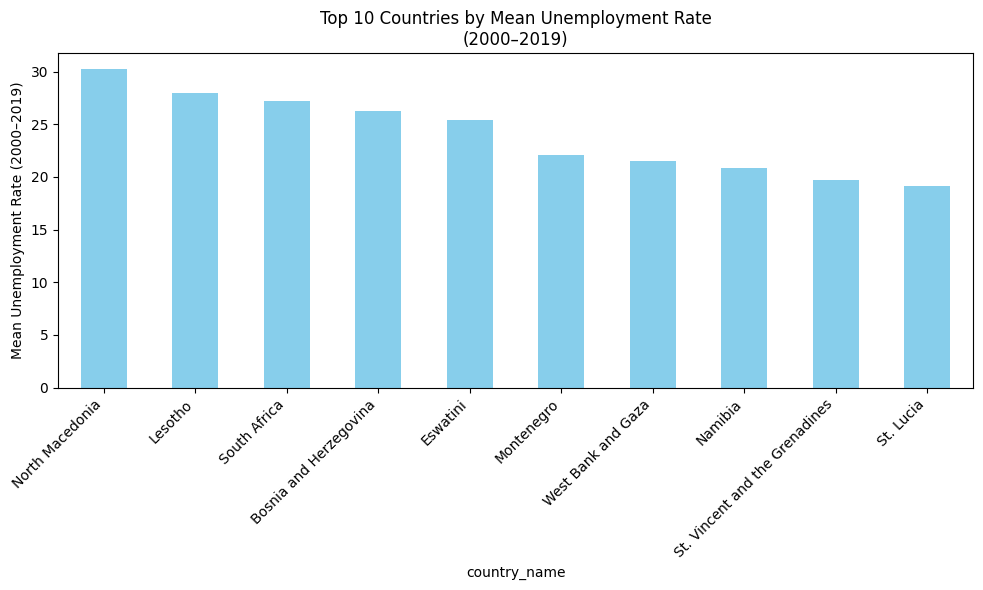

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned data
df = pd.read_csv('unemployment_cleaned.csv')

# Ensure unemployment_rate is numeric
df['unemployment_rate'] = pd.to_numeric(df['unemployment_rate'], errors='coerce')

# Compute mean unemployment rate for each country over 2000–2019
mean_rates = (
    df
    .groupby('country_name')['unemployment_rate']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 countries
plt.figure(figsize=(10, 6))
mean_rates.plot(kind='bar', color='skyblue')
plt.ylabel('Mean Unemployment Rate (2000–2019)')
plt.title('Top 10 Countries by Mean Unemployment Rate\n(2000–2019)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Load the original dataset
input_file = 'HDI.csv'  # replace with your file path
hdi_df = pd.read_csv(input_file)

# Filter for HDI entries and select the desired columns
clean_df = (
    hdi_df
    .loc[hdi_df['indexCode'] == 'HDI', ['country', 'countryIsoCode', 'year', 'value']]
    .rename(columns={
        'country': 'country_name',
        'countryIsoCode': 'country_code',
        'value': 'HDI'
    })
)

# Duplicate Denmark HDI data for Greenland
# ISO alpha-3 code for Greenland is 'GRL'
denmark_data = clean_df[clean_df['country_code'] == 'DNK']
if not denmark_data.empty:
    greenland_data = denmark_data.copy()
    greenland_data['country_name'] = 'Greenland'
    greenland_data['country_code'] = 'GRL'
    clean_df = pd.concat([clean_df, greenland_data], ignore_index=True)


clean_df.info()  # Check the data types and non-null counts

# Save the cleaned dataset
output_file = 'hdi_cleaned.csv'
clean_df.to_csv(output_file, index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3735 entries, 0 to 3734
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  3735 non-null   object 
 1   country_code  3735 non-null   object 
 2   year          3735 non-null   int64  
 3   HDI           3735 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 116.8+ KB


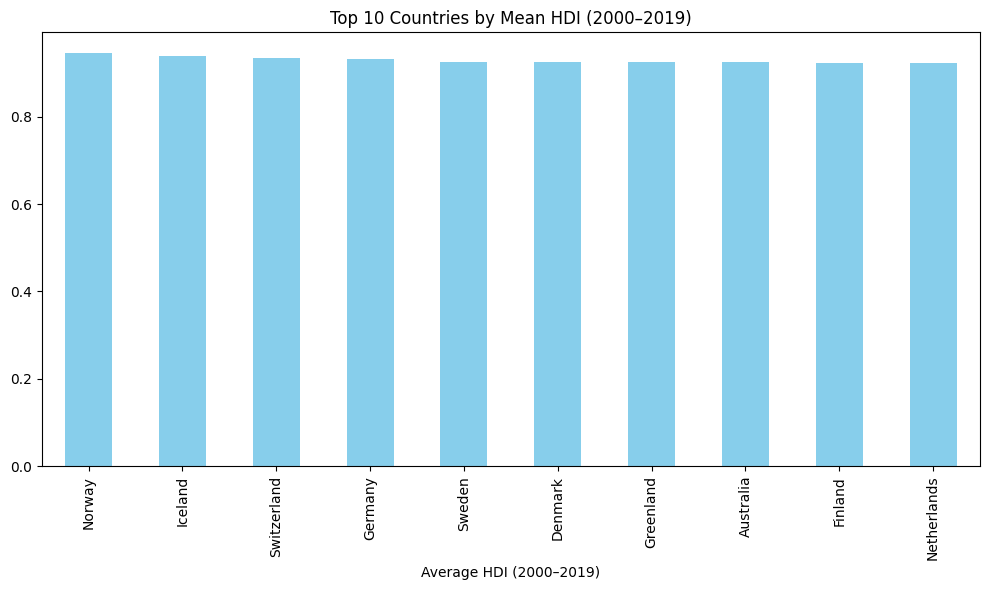

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your raw HDI dataset
#    Adjust the path to wherever your CSV lives.
hdi = clean_df

# 4) Filter to years 2000–2019 and compute mean HDI per country
hdi_period = hdi[hdi['year'].between(2000, 2019)]
mean_hdi = hdi_period.groupby('country_name')['HDI'].mean()

# 5) Select the top 10 and plot
top10 = mean_hdi.nlargest(10)

plt.figure(figsize=(10, 6))
# horizontal bar chart, skyblue bars
top10.plot(kind='bar', color='skyblue')
plt.xlabel('Average HDI (2000–2019)')
plt.title('Top 10 Countries by Mean HDI (2000–2019)')
plt.tight_layout()
plt.show()


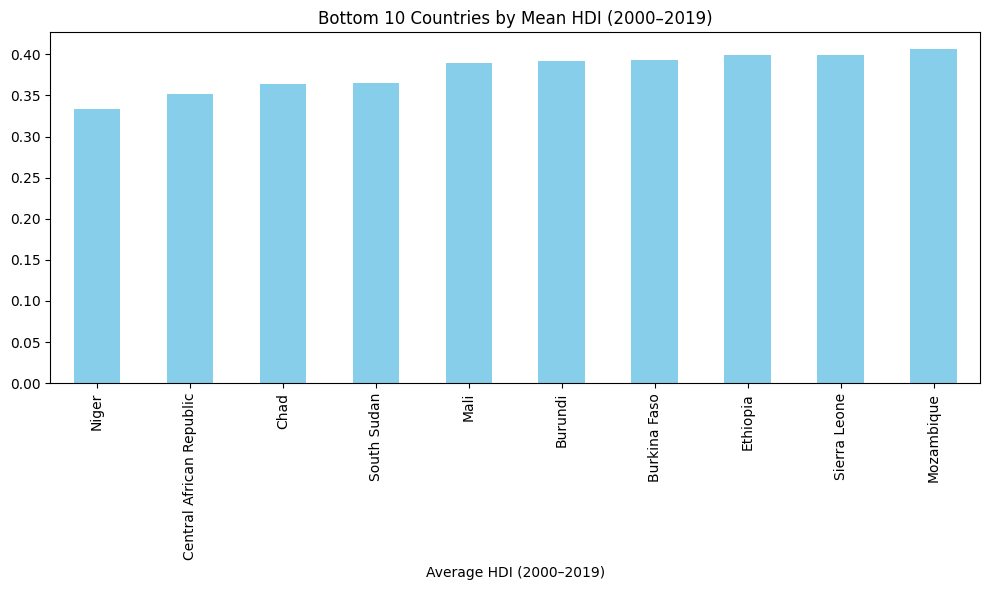

In [ ]:
bottom10 = mean_hdi.nsmallest(10)

plt.figure(figsize=(10, 6))
# horizontal bar chart, skyblue bars
# vertical bars
bottom10.plot(kind='bar', color='skyblue')
plt.xlabel('Average HDI (2000–2019)')
plt.title('Bottom 10 Countries by Mean HDI (2000–2019)')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd

# Load the WIID dataset (replace 'wiid.csv' with your actual file path)
df = pd.read_csv("wiid.csv")

# Inspect the column names to find the relevant ones
print(df.columns)

# Rename columns if needed based on actual WIID column names (example assumes naming like 'country', 'countrycode', etc.)
df_cleaned = df[["country", "c3", "gini_std", "gdp", "year"]].copy()

# Rename columns to match your desired output
df_cleaned.rename(columns={
    "country": "country_name",
    "c3": "country_code",
    "gini_reported": "gini_std"
}, inplace=True)

# remove years before 2000 and after 2019
df_cleaned = df_cleaned[(df_cleaned['year'] >= 2000) & (df_cleaned['year'] <= 2019)]
df_cleaned.info()  # Check the data types and non-null counts


Index(['id', 'country', 'c2', 'c3', 'year', 'region_wb', 'region_un',
       'region_un_sub', 'eu', 'incomegroup',
       ...
       'y96', 'y97', 'y98', 'y99', 'y100', 'sharetype', 'adjustment',
       'conversion', 'former', 'histent'],
      dtype='object', length=261)
<class 'pandas.core.frame.DataFrame'>
Index: 1510 entries, 0 to 2796
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  1510 non-null   object 
 1   country_code  1510 non-null   object 
 2   gini_std      1510 non-null   int64  
 3   gdp           1508 non-null   float64
 4   year          1510 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 70.8+ KB


In [13]:
# Save the cleaned dataset
df_cleaned.to_csv("wiid_cleaned.csv", index=False)

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1510 entries, 0 to 2796
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  1510 non-null   object 
 1   country_code  1510 non-null   object 
 2   gini_std      1510 non-null   int64  
 3   gdp           1508 non-null   float64
 4   year          1510 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 70.8+ KB
